In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# file_path = '/content/drive/My Drive/cs131/mpii_human_pose.csv'

# with open(file_path, 'r') as file:
#     data = file.read()

In [2]:
import cv2
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocess as mp
from sklearn.model_selection import train_test_split
from skimage import io, feature, data, color, exposure
# from preprocess_multi import *

# Read & Split Data

In [3]:
mpii_df = pd.read_csv('mpii_human_pose.csv')
mpii_numpy = mpii_df.to_numpy()

print("DataFrame:")
print(mpii_df.head())

print(f"\nData Shape: {mpii_numpy.shape}")
print(f"Num Unique Activities: {np.unique(mpii_numpy[:, -1]).shape}")
print(np.unique(mpii_numpy[:, -1]))

DataFrame:
   ID           NAME  r ankle_X  r ankle_Y  r knee_X  r knee_Y  r hip_X  \
0   1  015601864.jpg        620        394       616       269      573   
1   2  015599452.jpg         -1         -1        -1        -1      806   
2   3  005808361.jpg        804        711       816       510      908   
3   4  086617615.jpg        301        461       305       375      201   
4   5  060111501.jpg        980        322       896       318      865   

   r hip_Y  l hip_X  l hip_Y  ...  r shoulder_Y  l shoulder_X  l shoulder_Y  \
0      185      647      188  ...           167           692           185   
1      543      720      593  ...           281           719           299   
2      438     1040      454  ...           253          1067           253   
3      340      294      342  ...           261           314           264   
4      248      943      226  ...           147           923           123   

   l elbow_X  l elbow_Y  l wrist_X  l wrist_Y     Scale  Activi

In [4]:
mpii_numpy = mpii_numpy[np.isin(mpii_numpy[:, -1], ["bicycling", "conditioning exercise", "dancing", "sports"])]
mpii_numpy.shape

(6345, 37)

In [5]:
# Data split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Set seed for testing (TODO: Remove later)
seed = 42

# Randomize order of samples
indices = np.random.RandomState(seed=seed).permutation(len(mpii_numpy))
mpii_numpy_copy = mpii_numpy[indices]
category_labels = mpii_numpy[indices, -1]

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(mpii_numpy_copy, category_labels,
                                                                    test_size=1-train_ratio, stratify=category_labels,
                                                                    random_state=seed)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data,
                                                                              temp_labels,
                                                                              test_size=test_ratio/(test_ratio + validation_ratio),
                                                                              stratify=temp_labels,
                                                                              random_state=seed)

In [6]:
def resize_name(img_file: str) -> str:
  return img_file[:-4] + "_resized.png"

def get_img_file_path(img_file: str) -> str:
  return f"resized_images/{resize_name(img_file)}"

resized_images/085913036_resized.png


(-0.5, 1919.5, 1079.5, -0.5)

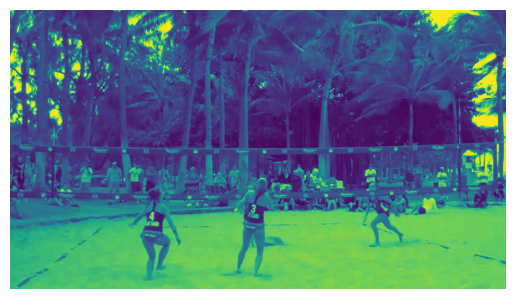

In [7]:
# Small test to make sure we have the right path
print(get_img_file_path(train_data[0][1]))
test_img = io.imread(get_img_file_path(train_data[0][1]), as_gray=True)
plt.imshow(test_img)
plt.axis('off')

# Process Data for Model

In [8]:
def pad_image(image, target_height=1080, target_width=1920):
    # Get the current height and width of the image
    current_height, current_width = image.shape
    
    # Calculate the amount of padding needed on the right and bottom sides
    pad_height = target_height - current_height
    pad_width = target_width - current_width
    
    # Pad the image with zeros
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant')
    
    return padded_image

In [9]:
def resize_image(input_image, output_rows=720, output_cols=1280):
    """Resize an image using the nearest neighbor method.

    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        output_rows (int): Number of rows in our desired output image.ss
        
        output_cols (int): Number of columns in our desired output image.

    Returns:
        np.ndarray: Resized image, with shape `(output_rows, output_cols, 3)`.
    """
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    # 1. Create the resized output image
    output_image = np.zeros(shape=(output_rows, output_cols, 3))

    # 2. Populate the `output_image` array using values from `input_image`
    #    > This should require two nested for loops!

    ### YOUR CODE HERE
    row_scale = input_rows / output_rows
    col_scale = input_cols / output_cols
    for row in range(output_rows):
        for col in range(output_cols):
            output_image[row, col, :] = input_image[int(row * row_scale), int(col * col_scale), :]
    ### END YOUR CODE

    # 3. Return the output image
    return output_image

In [11]:
def hog_feature(image_path):
  image = pad_image(io.imread(image_path, as_gray=True))
  pixel_per_cell = min(image.shape[0]/16, image.shape[1]/16)
  hog_feature = feature.hog(image, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                            block_norm='L2-Hys', feature_vector=True, transform_sqrt=True)
  return hog_feature

In [12]:
# Set feature_vector=False --> get (22, 42, 3, 3, 9)
hog_feature(get_img_file_path(train_data[0][1])).shape

(29484,)

In [13]:
# Really slow :(
def preprocess_data(data_set):
  X = []
  y = []

  for data_pt in data_set:
    img_file = get_img_file_path(data_pt[1])
    X.append(hog_feature(img_file))
    y.append(data_pt[2:-3])

  X = np.asarray(X)
  y = np.asarray(y)
  return X, y

In [15]:
def preprocess(data_pt):
  # img_file = get_img_file_path(data_pt[1])
  img_file = f"images/{data_pt[1]}"
  X = hog_feature(img_file)
  y = data_pt[2:-3]
  return X, y, img_file

def parallel_preprocess(data_set):
  with mp.Pool() as pool:
    results = pool.map(preprocess, data_set)
  X, y, imgs = zip(*results)
  return np.array(X), np.array(y), np.array(imgs)

In [16]:
X_train, y_train, train_images = parallel_preprocess(train_data)

In [17]:
X_validation, y_validation, validation_images = parallel_preprocess(validation_data)

In [18]:
X_test, y_test, test_images = parallel_preprocess(test_data)

## Save data as files

In [ ]:
np.save(f"processed_data/filtered_X_train.npy", X_train)
np.save(f"processed_data/filtered_y_train.npy", y_train)
np.save(f"processed_data/filtered_train_images.npy", train_images)

In [ ]:
np.save(f"processed_data/filtered_X_validation.npy", X_validation)
np.save(f"processed_data/filtered_y_validation.npy", y_validation)
np.save(f"processed_data/filtered_validation_images.npy", validation_images)

In [ ]:
np.save(f"processed_data/filtered_X_test.npy", X_test)
np.save(f"processed_data/filtered_y_test.npy", y_test)
np.save(f"processed_data/filtered_test_images.npy", test_images)

# Model Training

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(100, 720, 1280, 3)
(100, 32)
(10, 720, 1280, 3)
(10, 32)
(10, 720, 1280, 3)
(10, 32)


In [19]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_validation = X_validation.astype(float)
y_validation = y_validation.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [21]:
NUM_FEATURES = X_train.shape[1]
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape=(input_shape,)),
        tf.keras.layers.LeakyReLU(0.2),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.LeakyReLU(0.2),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.LeakyReLU(0.2),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(32)  # Output layer for 8 coordinates (2D)
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # Adjusted learning rate
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

def train_and_evaluate(epochs, batch_size):
    model = create_model(NUM_FEATURES)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, y_validation))

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)

    return model

In [22]:
trained_model = train_and_evaluate(25, 32)

Epoch 1/25


2024-03-19 21:28:58.532046: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


159/159 [==============================] - 2s 9ms/step - loss: 279303.1562 - val_loss: 143368.7812
Epoch 2/25
159/159 [==============================] - 1s 9ms/step - loss: 101214.8125 - val_loss: 73814.6328
Epoch 3/25
159/159 [==============================] - 1s 9ms/step - loss: 66219.3750 - val_loss: 58313.1992
Epoch 4/25
159/159 [==============================] - 1s 9ms/step - loss: 56959.2578 - val_loss: 54046.7266
Epoch 5/25
159/159 [==============================] - 1s 9ms/step - loss: 54235.8945 - val_loss: 52764.7109
Epoch 6/25
159/159 [==============================] - 1s 9ms/step - loss: 52991.4062 - val_loss: 52476.5977
Epoch 7/25
159/159 [==============================] - 1s 9ms/step - loss: 52350.9805 - val_loss: 51667.1992
Epoch 8/25
159/159 [==============================] - 1s 9ms/step - loss: 51754.9023 - val_loss: 51450.4922
Epoch 9/25
159/159 [==============================] - 1s 9ms/step - loss: 51342.4414 - val_loss: 51231.5742
Epoch 10/25
159/159 [===============

# Evaluation

In [23]:
def skeleton_lines(joints, color):
    plt.plot(np.append(joints[:3, 0], [joints[6, 0]]), np.append(joints[:3, 1], [joints[6, 1]]), color=color)  # Right leg
    plt.plot(np.append([joints[6, 0]], joints[3:6, 0]), np.append([joints[6, 1]], joints[3:6, 1]), color=color)  # Left leg
    plt.plot(joints[6:10, 0], joints[6:10, 1], color=color)
    plt.plot(np.append(joints[10:13, 0], [joints[7, 0]]), np.append(joints[10:13, 1], [joints[7, 1]]), color=color)  # Right arm
    plt.plot(np.append([joints[7, 0]], joints[13:, 0]), np.append([joints[7, 1]], joints[13:, 1]), color=color)  # Left arm

In [24]:
def get_original_image(img_file):
    return f"images/{img_file[15:-12]}.jpg"

20/20 [==============================] - 0s 4ms/step


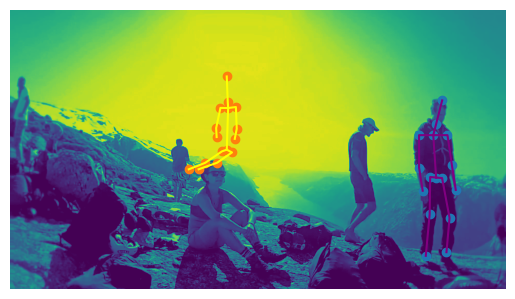

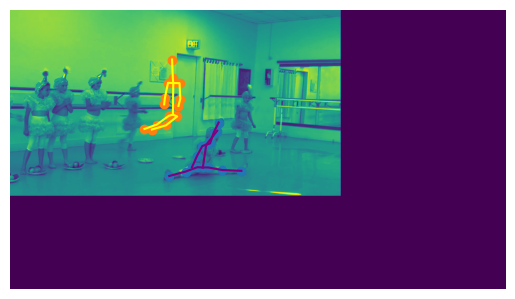

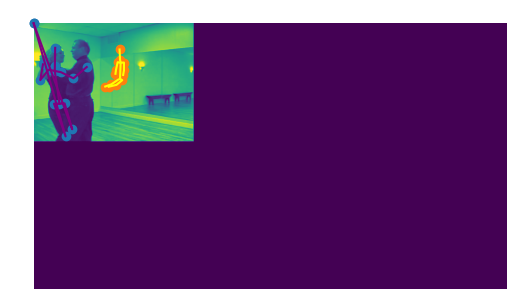

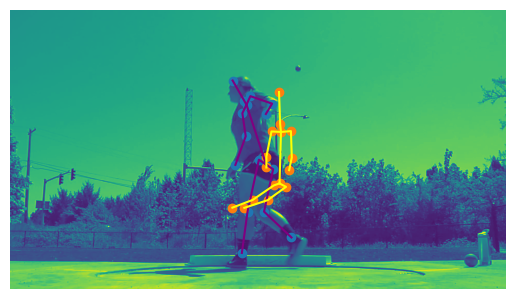

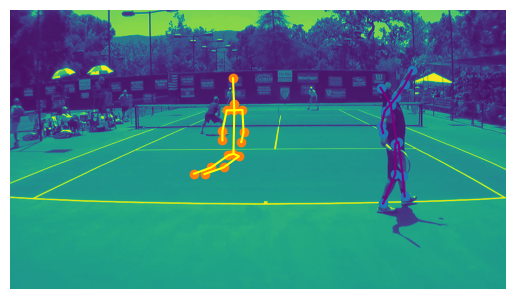

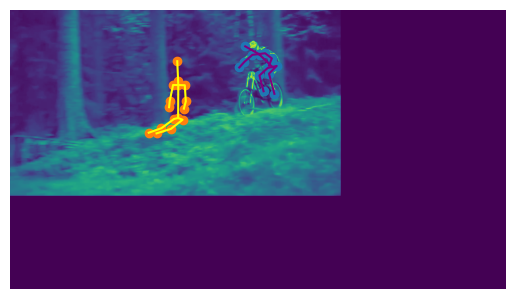

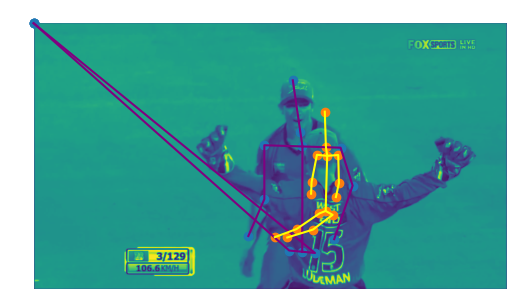

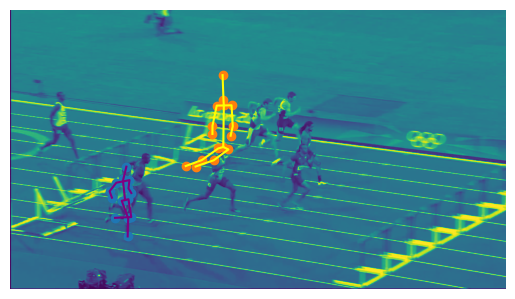

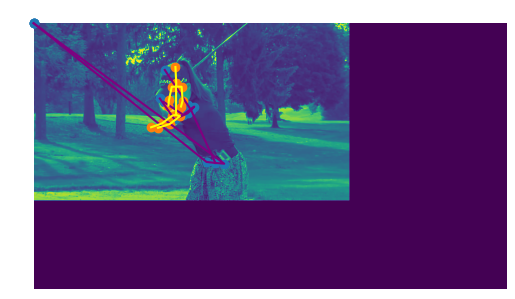

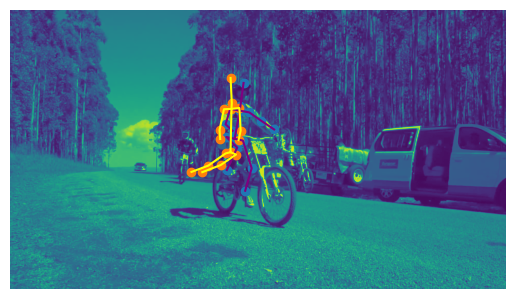

In [26]:
y_est = trained_model.predict(X_test)

for i in range(10, 20):
    true_points = y_test[i].reshape((16, 2))
    est_points = y_est[i].reshape((16, 2))

    image = pad_image(io.imread(test_images[i], as_gray=True))

    # Display the image using Matplotlib
    plt.imshow(image)
    plt.scatter(true_points[:, 0], true_points[:, 1])
    plt.scatter(est_points[:, 0], est_points[:, 1])
    skeleton_lines(true_points, "purple")
    skeleton_lines(est_points, "yellow")
    plt.axis('off')  # Turn off axis labels
    plt.show()